In [41]:
import numpy as np 
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split
import pandas as pd
from tqdm import tqdm

import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [42]:
#----------------------Load the Excel file-----------------------
def load_data(file_path, sheet_name):
    sheet_name = sheet_name
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) 
    return df, index_tensor

In [43]:
import pandas as pd
import torch

class FeatureProcessor:
    def __init__(self, file_path='D:/01IscBML/', file_name = 'train_del_keep1700.xlsx'):
        self.category_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        self.data_path = file_path + file_name
        self.df, self.index_tensor = self.load_data(self.data_path)  # load the df and index tensor as self attributes
        self.combined_features, self.sequence_length = self.feature_processing()
        self.labels_tensor = self.label()

    def __len__(self):
        return len(self.df.shape[0])

    def load_data(self, data_path):
        df = pd.read_excel(data_path)
        index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int)-1 # Warning: 0-indexed
        return df, index_tensor

    def sequence_to_one_hot(self, sequence, categories="ATCG"):
        category_map = {char: idx for idx, char in enumerate(categories)}
        one_hot = []
        for char in sequence:
            one_hot_char = [0] * len(categories)
            if char in category_map:
                one_hot_char[category_map[char]] = 1
            one_hot.append(one_hot_char)
        return one_hot

    def feature_processing(self):
        sequence_data = self.df['Target_Site_sequence']
        sequence_length = len(sequence_data.iloc[0])
        one_hot_features = sequence_data.apply(self.sequence_to_one_hot)

        features_tensor = torch.tensor(list(one_hot_features), dtype=torch.float32)

        index_one_hot_features = []
        for idx in self.index_tensor:
            index_one_hot = [0] * sequence_length
            if 0 <= idx < sequence_length:
                index_one_hot[idx] = 1
            index_one_hot_features.append(index_one_hot)

        index_one_hot_tensor = torch.tensor(index_one_hot_features, dtype=torch.float32).unsqueeze(2)

        combined_features = torch.cat((features_tensor, index_one_hot_tensor), dim=2)
        return combined_features, sequence_length
    
    def label(self):
        #---------------------Prepare labels tensor-----------------------
        labels_tensor = torch.tensor(self.df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels
        return labels_tensor
    



In [44]:
label_data = FeatureProcessor(file_path='D:/01IscBML/').labels_tensor
combined_features = FeatureProcessor(file_path='D:/01IscBML/').combined_features

In [45]:
sequence_length = FeatureProcessor(file_path='D:/01IscBML/').sequence_length

In [46]:
sequence_length

56

In [47]:
#---------------------Prepare labels tensor-----------------------
# labels_tensor = torch.tensor(df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels

#---------------------Create dataset and dataloader-----------------
dataset = TensorDataset(combined_features, label_data)

# Turn shuffle to False if you want to keep the predefined order of the data
# dataloader = DataLoader(dataset, batch_size=32, shuffle=False)  # You can adjust the batch size as needed
# i= 0
# #----------------------Example to check batches---------------------
# for i, (batch_features, batch_labels) in enumerate(dataloader):
#     print("Batch", i)
#     print("Features Batch Shape:", batch_features[20,20:36,:])  # (batch_size, sequence_length, channel_size)
#     print("Labels Batch Shape:", batch_labels[20])  # (batch_size, 1)
#     i+=1
#     if i == 2:
#         break


In [48]:
# Define a simple 1D CNN model
# class CNN(nn.Module):
#     def __init__(self, sequence_length):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=5, out_channels=16, kernel_size=3, padding=1)  # Update in_channels to 5
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2)
        
#         # Dynamically compute the size of the flattened feature map
#         self.flattened_size = 16 * (sequence_length // 2)  # After one max pooling (sequence_length // 2)
#         self.fc1 = nn.Linear(self.flattened_size, 1)  # Fully connected layer
        
#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.fc1(x)
#         return x

# class OptimizedCNN(nn.Module):
#     def __init__(self, sequence_length):
#         super(OptimizedCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=5, out_channels=16, kernel_size=3, padding=1)  # 卷积层
#         self.relu = nn.ReLU()
        
#         # 计算全连接层输入的维度
#         self.flattened_size = 16 * sequence_length  # 无池化层时，序列长度不变
#         self.fc1 = nn.Linear(self.flattened_size, 1)  # 全连接层

#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # 调整维度为 (batch_size, channels, sequence_length)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = x.view(x.size(0), -1)  # 展平
#         x = self.fc1(x)
#         return x

In [49]:
class LocalCNN(nn.Module):
    def __init__(self, sequence_length, kernel_size=21):
        super(LocalCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.relu = nn.ReLU()
        self.hardtanh = nn.Hardtanh(min_val=0, max_val=1)
        # self.clipper = nn.clippedReLU()
        self.fc1 = nn.Linear(32 * sequence_length, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
        x = self.conv1(x)  # Apply convolution
        x = self.relu(x)
        x = self.conv2(x) # Apply convolution
        x = self.relu(x)
        x = self.conv3(x)  # Apply convolution
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


class MLP(nn.Module):
    def __init__(self, sequence_length):
        super(MLP, self).__init__()
        input_size = sequence_length * 5  # Flattened input size
        hidden_size = 512  # Number of neurons in each hidden layer
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),  # Add dropout for regularization
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),  # Final output layer
            nn.Hardtanh(min_val=0, max_val=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input to (batch_size, sequence_length * 5)
        x = self.layers(x)
        return x

In [50]:
#------------------split train&validation dataset---------------------
from torch.utils.data import random_split, DataLoader

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size) 

val_size = dataset_size - train_size  
print(val_size)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_size, shuffle=False, drop_last=True)    

for i, train_data in enumerate(train_dataloader):
    print("Batch", i)
    channel = train_data[0].shape[2]
    print("Features Batch Shape:", train_data[0].shape)  # (batch_size, sequence_length, channel_size)
    print("Labels Batch Shape:", train_data[1].shape)  # (batch_size, 1)
    i+=1
    if i == 2:
        break

2292
Batch 0
Features Batch Shape: torch.Size([64, 56, 5])
Labels Batch Shape: torch.Size([64, 1])
Batch 1
Features Batch Shape: torch.Size([64, 56, 5])
Labels Batch Shape: torch.Size([64, 1])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 1/100: 100%|██████████| 143/143 [00:02<00:00, 68.00it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 2/100: 100%|██████████| 143/143 [00:01<00:00, 72.58it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 3/100: 100%|██████████| 143/143 [00:01<00:00, 73.97it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 4/100: 100%|██████████| 143/143 [00:01<00:00, 75.23it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 5/100: 100%|██████████| 143/143 [00:02<00:00, 68.48it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 6/100: 100%|██████████| 143/143 [00:02<00:00, 61.83it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 7/100: 100%|██████████| 143/143 [00:02<00:00, 64.22it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 8/100: 100%|██████████| 143/143 [00:02<00:00, 62.94it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 9/100: 100%|██████████| 143/143 [00:02<00:00, 63.59it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 10/100: 100%|██████████| 143/143 [00:02<00:00, 63.36it/s]


Model saved with Pearson correlation: 0.7795
Epoch [10/100]
Training Loss: 0.0089
Validation Pearson Correlation: 0.7785


Epoch 11/100: 100%|██████████| 143/143 [00:02<00:00, 53.68it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 12/100: 100%|██████████| 143/143 [00:02<00:00, 49.46it/s]


Model saved with Pearson correlation: 0.7852
Epoch [12/100]
Training Loss: 0.0067
Validation Pearson Correlation: 0.7770


Epoch 13/100: 100%|██████████| 143/143 [00:02<00:00, 52.59it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 14/100: 100%|██████████| 143/143 [00:09<00:00, 14.90it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 15/100: 100%|██████████| 143/143 [00:08<00:00, 16.56it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 16/100: 100%|██████████| 143/143 [00:13<00:00, 10.54it/s]


Model saved with Pearson correlation: 0.7924
Epoch [16/100]
Training Loss: 0.0037
Validation Pearson Correlation: 0.7852


Epoch 17/100: 100%|██████████| 143/143 [00:14<00:00,  9.88it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 18/100: 100%|██████████| 143/143 [00:09<00:00, 14.57it/s]


Model saved with Pearson correlation: 0.8006
Epoch [18/100]
Training Loss: 0.0028
Validation Pearson Correlation: 0.7936


Epoch 19/100: 100%|██████████| 143/143 [00:10<00:00, 13.31it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 20/100: 100%|██████████| 143/143 [00:12<00:00, 11.41it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 21/100: 100%|██████████| 143/143 [00:13<00:00, 10.62it/s]


Model saved with Pearson correlation: 0.8061
Epoch [21/100]
Training Loss: 0.0022
Validation Pearson Correlation: 0.8023


Epoch 22/100: 100%|██████████| 143/143 [00:09<00:00, 15.33it/s]


Model saved with Pearson correlation: 0.8061
Epoch [22/100]
Training Loss: 0.0020
Validation Pearson Correlation: 0.8056


Epoch 23/100: 100%|██████████| 143/143 [00:10<00:00, 13.78it/s]


Model saved with Pearson correlation: 0.8061
Epoch [23/100]
Training Loss: 0.0020
Validation Pearson Correlation: 0.8025


Epoch 24/100: 100%|██████████| 143/143 [00:12<00:00, 11.04it/s]


Model saved with Pearson correlation: 0.8061
Epoch [24/100]
Training Loss: 0.0018
Validation Pearson Correlation: 0.8012


Epoch 25/100: 100%|██████████| 143/143 [00:11<00:00, 12.89it/s]


Model saved with Pearson correlation: 0.8061
Epoch [25/100]
Training Loss: 0.0017
Validation Pearson Correlation: 0.8049


Epoch 26/100: 100%|██████████| 143/143 [00:09<00:00, 14.48it/s]


Model saved with Pearson correlation: 0.8061
Epoch [26/100]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8042


Epoch 27/100: 100%|██████████| 143/143 [00:12<00:00, 11.83it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 28/100: 100%|██████████| 143/143 [00:14<00:00, 10.09it/s]


Model saved with Pearson correlation: 0.8093
Epoch [28/100]
Training Loss: 0.0014
Validation Pearson Correlation: 0.8061


Epoch 29/100: 100%|██████████| 143/143 [00:13<00:00, 10.89it/s]


Model saved with Pearson correlation: 0.8093
Epoch [29/100]
Training Loss: 0.0015
Validation Pearson Correlation: 0.8053


Epoch 30/100: 100%|██████████| 143/143 [00:08<00:00, 16.52it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 31/100: 100%|██████████| 143/143 [00:12<00:00, 11.43it/s]


Model saved with Pearson correlation: 0.8172
Epoch [31/100]
Training Loss: 0.0016
Validation Pearson Correlation: 0.8120


Epoch 32/100: 100%|██████████| 143/143 [00:14<00:00, 10.14it/s]


Model saved with Pearson correlation: 0.8172
Epoch [32/100]
Training Loss: 0.0015
Validation Pearson Correlation: 0.8076


Epoch 33/100: 100%|██████████| 143/143 [00:10<00:00, 14.03it/s]


Model saved with Pearson correlation: 0.8172
Epoch [33/100]
Training Loss: 0.0014
Validation Pearson Correlation: 0.8147


Epoch 34/100: 100%|██████████| 143/143 [00:08<00:00, 16.07it/s]


Model saved with Pearson correlation: 0.8172
Epoch [34/100]
Training Loss: 0.0014
Validation Pearson Correlation: 0.8115


Epoch 35/100: 100%|██████████| 143/143 [00:12<00:00, 11.51it/s]


Model saved with Pearson correlation: 0.8172
Epoch [35/100]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8115


Epoch 36/100: 100%|██████████| 143/143 [00:13<00:00, 10.76it/s]


Model saved with Pearson correlation: 0.8172
Epoch [36/100]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8140


Epoch 37/100: 100%|██████████| 143/143 [00:10<00:00, 14.11it/s]


Model saved with Pearson correlation: 0.8172
Epoch [37/100]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8161


Epoch 38/100: 100%|██████████| 143/143 [00:11<00:00, 12.50it/s]


Model saved with Pearson correlation: 0.8172
Epoch [38/100]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8124


Epoch 39/100: 100%|██████████| 143/143 [00:14<00:00,  9.82it/s]


Model saved with Pearson correlation: 0.8172
Epoch [39/100]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8148


Epoch 40/100: 100%|██████████| 143/143 [00:13<00:00, 10.38it/s]


Model saved with Pearson correlation: 0.8172
Epoch [40/100]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8136


Epoch 41/100: 100%|██████████| 143/143 [00:09<00:00, 15.58it/s]


Model saved with Pearson correlation: 0.8172
Epoch [41/100]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8089


Epoch 42/100: 100%|██████████| 143/143 [00:13<00:00, 10.75it/s]


Model saved with Pearson correlation: 0.8172
Epoch [42/100]
Training Loss: 0.0013
Validation Pearson Correlation: 0.8090


Epoch 43/100: 100%|██████████| 143/143 [00:13<00:00, 10.58it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 44/100: 100%|██████████| 143/143 [00:11<00:00, 12.97it/s]


Model saved with Pearson correlation: 0.8172
Epoch [44/100]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8128


Epoch 45/100: 100%|██████████| 143/143 [00:10<00:00, 13.79it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 46/100: 100%|██████████| 143/143 [00:13<00:00, 10.60it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 47/100: 100%|██████████| 143/143 [00:14<00:00, 10.13it/s]


Model saved with Pearson correlation: 0.8208
Epoch [47/100]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8164


Epoch 48/100: 100%|██████████| 143/143 [00:07<00:00, 18.22it/s]


Model saved with Pearson correlation: 0.8208
Epoch [48/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8181


Epoch 49/100: 100%|██████████| 143/143 [00:12<00:00, 11.36it/s]


Model saved with Pearson correlation: 0.8208
Epoch [49/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8180


Epoch 50/100: 100%|██████████| 143/143 [00:13<00:00, 10.55it/s]


Model saved with Pearson correlation: 0.8208
Epoch [50/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8146


Epoch 51/100: 100%|██████████| 143/143 [00:12<00:00, 11.83it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 52/100: 100%|██████████| 143/143 [00:08<00:00, 16.12it/s]


Model saved with Pearson correlation: 0.8216
Epoch [52/100]
Training Loss: 0.0011
Validation Pearson Correlation: 0.8132


Epoch 53/100: 100%|██████████| 143/143 [00:14<00:00, 10.14it/s]


Model saved with Pearson correlation: 0.8216
Epoch [53/100]
Training Loss: 0.0012
Validation Pearson Correlation: 0.8148


Epoch 54/100: 100%|██████████| 143/143 [00:10<00:00, 14.07it/s]


Model saved with Pearson correlation: 0.8216
Epoch [54/100]
Training Loss: 0.0010
Validation Pearson Correlation: 0.8192


Epoch 55/100: 100%|██████████| 143/143 [00:03<00:00, 38.26it/s]


Model saved with Pearson correlation: 0.8216
Epoch [55/100]
Training Loss: 0.0010
Validation Pearson Correlation: 0.8174


Epoch 56/100: 100%|██████████| 143/143 [00:02<00:00, 59.29it/s]


Model saved with Pearson correlation: 0.8216
Epoch [56/100]
Training Loss: 0.0010
Validation Pearson Correlation: 0.8132


Epoch 57/100: 100%|██████████| 143/143 [00:02<00:00, 59.84it/s]


Model saved with Pearson correlation: 0.8216
Epoch [57/100]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8196


Epoch 58/100: 100%|██████████| 143/143 [00:02<00:00, 59.67it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 59/100: 100%|██████████| 143/143 [00:02<00:00, 61.95it/s]


Model saved with Pearson correlation: 0.8232
Epoch [59/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8206


Epoch 60/100: 100%|██████████| 143/143 [00:02<00:00, 61.32it/s]


Model saved with Pearson correlation: 0.8232
Epoch [60/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8215


Epoch 61/100: 100%|██████████| 143/143 [00:10<00:00, 13.74it/s]


Model saved with Pearson correlation: 0.8232
Epoch [61/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8198


Epoch 62/100: 100%|██████████| 143/143 [00:12<00:00, 11.66it/s]


Model saved with Pearson correlation: 0.8232
Epoch [62/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8174


Epoch 63/100: 100%|██████████| 143/143 [00:12<00:00, 11.11it/s]


Model saved with Pearson correlation: 0.8232
Epoch [63/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8232


Epoch 64/100: 100%|██████████| 143/143 [00:11<00:00, 12.94it/s]


Model saved with Pearson correlation: 0.8232
Epoch [64/100]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8218


Epoch 65/100: 100%|██████████| 143/143 [00:10<00:00, 13.09it/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 56]           3,392
              ReLU-2               [-1, 32, 56]               0
            Conv1d-3               [-1, 32, 56]          21,536
              ReLU-4               [-1, 32, 56]               0
            Conv1d-5               [-1, 32, 56]          21,536
              ReLU-6               [-1, 32, 56]               0
            Linear-7                  [-1, 128]         229,504
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
             ReLU-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 280,129
Trainable params: 280,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Epoch 66/100: 100%|██████████| 143/143 [00:13<00:00, 10.68it/s]


Model saved with Pearson correlation: 0.8246
Epoch [66/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8190


Epoch 67/100: 100%|██████████| 143/143 [00:12<00:00, 11.25it/s]


Model saved with Pearson correlation: 0.8246
Epoch [67/100]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8203


Epoch 68/100: 100%|██████████| 143/143 [00:08<00:00, 16.29it/s]


Model saved with Pearson correlation: 0.8246
Epoch [68/100]
Training Loss: 0.0009
Validation Pearson Correlation: 0.8155


Epoch 69/100: 100%|██████████| 143/143 [00:11<00:00, 12.23it/s]


Model saved with Pearson correlation: 0.8246
Epoch [69/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8184


Epoch 70/100: 100%|██████████| 143/143 [00:12<00:00, 11.10it/s]


Model saved with Pearson correlation: 0.8246
Epoch [70/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8200


Epoch 71/100: 100%|██████████| 143/143 [00:12<00:00, 11.55it/s]


Model saved with Pearson correlation: 0.8246
Epoch [71/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8192


Epoch 72/100: 100%|██████████| 143/143 [00:08<00:00, 17.17it/s]


Model saved with Pearson correlation: 0.8246
Epoch [72/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8214


Epoch 73/100: 100%|██████████| 143/143 [00:13<00:00, 10.31it/s]


Model saved with Pearson correlation: 0.8246
Epoch [73/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8172


Epoch 74/100: 100%|██████████| 143/143 [00:13<00:00, 10.64it/s]


Model saved with Pearson correlation: 0.8246
Epoch [74/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8178


Epoch 75/100: 100%|██████████| 143/143 [00:10<00:00, 14.02it/s]


Model saved with Pearson correlation: 0.8246
Epoch [75/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8162


Epoch 76/100: 100%|██████████| 143/143 [00:10<00:00, 13.34it/s]


Model saved with Pearson correlation: 0.8246
Epoch [76/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8183


Epoch 77/100: 100%|██████████| 143/143 [00:13<00:00, 10.42it/s]


Model saved with Pearson correlation: 0.8246
Epoch [77/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8204


Epoch 78/100: 100%|██████████| 143/143 [00:13<00:00, 10.75it/s]


Model saved with Pearson correlation: 0.8246
Epoch [78/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8192


Epoch 79/100: 100%|██████████| 143/143 [00:08<00:00, 16.57it/s]


Model saved with Pearson correlation: 0.8246
Epoch [79/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8125


Epoch 80/100: 100%|██████████| 143/143 [00:12<00:00, 11.87it/s]


Model saved with Pearson correlation: 0.8246
Epoch [80/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8160


Epoch 81/100: 100%|██████████| 143/143 [00:13<00:00, 10.69it/s]


Model saved with Pearson correlation: 0.8246
Epoch [81/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8204


Epoch 82/100: 100%|██████████| 143/143 [00:09<00:00, 14.51it/s]


Model saved with Pearson correlation: 0.8246
Epoch [82/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8219


Epoch 83/100: 100%|██████████| 143/143 [00:09<00:00, 15.85it/s]


Model saved with Pearson correlation: 0.8246
Epoch [83/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8188


Epoch 84/100: 100%|██████████| 143/143 [00:12<00:00, 11.04it/s]


Model saved with Pearson correlation: 0.8246
Epoch [84/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8196


Epoch 85/100: 100%|██████████| 143/143 [00:11<00:00, 12.46it/s]


Model saved with Pearson correlation: 0.8246
Epoch [85/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8229


Epoch 86/100: 100%|██████████| 143/143 [00:10<00:00, 13.30it/s]


Model saved with Pearson correlation: 0.8246
Epoch [86/100]
Training Loss: 0.0006
Validation Pearson Correlation: 0.8174


Epoch 87/100: 100%|██████████| 143/143 [00:09<00:00, 15.54it/s]


Model saved with Pearson correlation: 0.8246
Epoch [87/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8160


Epoch 88/100: 100%|██████████| 143/143 [00:12<00:00, 11.29it/s]


Model saved with Pearson correlation: 0.8246
Epoch [88/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8238


Epoch 89/100: 100%|██████████| 143/143 [00:12<00:00, 11.54it/s]


Model saved with Pearson correlation: 0.8246
Epoch [89/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8176


Epoch 90/100: 100%|██████████| 143/143 [00:09<00:00, 15.09it/s]


Model saved with Pearson correlation: 0.8246
Epoch [90/100]
Training Loss: 0.0008
Validation Pearson Correlation: 0.8189


Epoch 91/100: 100%|██████████| 143/143 [00:09<00:00, 15.29it/s]


Model saved with Pearson correlation: 0.8246
Epoch [91/100]
Training Loss: 0.0007
Validation Pearson Correlation: 0.8161


Epoch 92/100: 100%|██████████| 143/143 [00:12<00:00, 11.06it/s]


Model saved with Pearson correlation: 0.8246
Epoch [92/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8176


Epoch 93/100: 100%|██████████| 143/143 [00:12<00:00, 11.18it/s]


Model saved with Pearson correlation: 0.8246
Epoch [93/100]
Training Loss: 0.0004
Validation Pearson Correlation: 0.8229


Epoch 94/100: 100%|██████████| 143/143 [00:07<00:00, 19.95it/s]


Model saved with Pearson correlation: 0.8246
Epoch [94/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8202


Epoch 95/100: 100%|██████████| 143/143 [00:12<00:00, 11.89it/s]


Model saved with Pearson correlation: 0.8246
Epoch [95/100]
Training Loss: 0.0002
Validation Pearson Correlation: 0.8185


Epoch 96/100: 100%|██████████| 143/143 [00:13<00:00, 10.86it/s]


Model saved with Pearson correlation: 0.8246
Epoch [96/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8203


Epoch 97/100: 100%|██████████| 143/143 [00:12<00:00, 11.59it/s]


Model saved with Pearson correlation: 0.8246
Epoch [97/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8213


Epoch 98/100: 100%|██████████| 143/143 [00:08<00:00, 17.57it/s]


Model saved with Pearson correlation: 0.8246
Epoch [98/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8197


Epoch 99/100: 100%|██████████| 143/143 [00:12<00:00, 11.41it/s]


Model saved with Pearson correlation: 0.8246
Epoch [99/100]
Training Loss: 0.0003
Validation Pearson Correlation: 0.8224


Epoch 100/100: 100%|██████████| 143/143 [00:12<00:00, 11.85it/s]


Model saved with Pearson correlation: 0.8246
Epoch [100/100]
Training Loss: 0.0005
Validation Pearson Correlation: 0.8181


<Figure size 640x480 with 0 Axes>

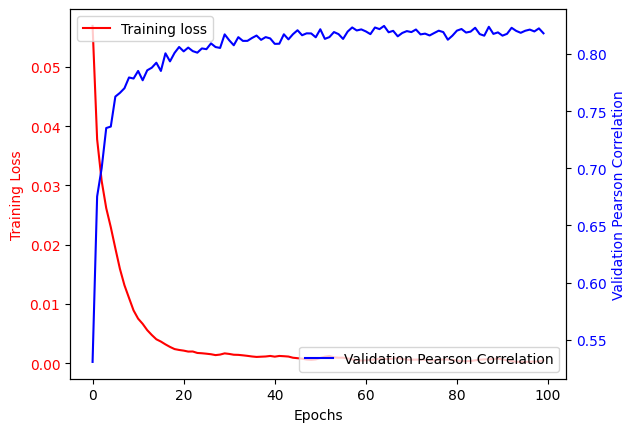

In [51]:
import time
from torchsummary import summary
import os
timestamp = time.strftime('%Y%m%d_%H%M%S')
save_dir = f'D:/01IscBML/logfile/{timestamp}/'
os.mkdir(save_dir)
# Initialize the model, loss function, and optimizer
model = LocalCNN(sequence_length = sequence_length)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training and validation setup
num_epochs = 100  # Adjust as needed

# Function to calculate Pearson correlation coefficient
def pearson_correlation(predicted, actual):
    pred_mean = predicted.mean()
    actual_mean = actual.mean()
    covariance = ((predicted - pred_mean) * (actual - actual_mean)).sum()
    pred_std = ((predicted - pred_mean) ** 2).sum().sqrt()
    actual_std = ((actual - actual_mean) ** 2).sum().sqrt()
    return (covariance / (pred_std * actual_std)).item()

plot_loss = []
plot_pearson = []
max_r = 0.0
for epoch in range(num_epochs):
    if epoch == 0:  # Save the architecture only in the first epoch
        ## for MLP
        input_size = sequence_length * channel
        model_architecture = summary(model, input_size=(sequence_length, channel))
    model.train()  # Set model to training mode
    running_loss = 0.0

    train_pearson = 0.0  # To accumulate Pearson correlation coefficient for training
    
    # Training loop
    for batch_features, batch_labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to appropriate device (e.g., GPU if available)
        batch_features, batch_labels = batch_features.to('cpu'), batch_labels.to('cpu')
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate Pearson correlation for the batch
        predicted = outputs.squeeze(1)  # Remove singleton dimension
        actual = batch_labels.squeeze(1)
        train_pearson += pearson_correlation(predicted, actual)

    # Compute average training loss and Pearson correlation for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    plot_loss.append(epoch_loss)
    epoch_train_pearson = train_pearson / len(train_dataloader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_pearson = 0.0
    with torch.no_grad():
        for val_features, val_labels in val_dataloader:  # Use a separate validation DataLoader
            val_features, val_labels = val_features.to('cpu'), val_labels.to('cpu')
            
            val_outputs = model(val_features)
            predicted = val_outputs.squeeze(1)
            # print(predicted)
            actual = val_labels.squeeze(1)
            # print(actual)

            # Calculate Pearson correlation for the validation set
            val_pearson += pearson_correlation(predicted, actual)
    
    # Compute average validation Pearson correlation for the epoch
    epoch_val_pearson = val_pearson / len(val_dataloader)
    plot_pearson.append(epoch_val_pearson)

    ##save the model and architecture
    if epoch_val_pearson > max_r:
        max_r = epoch_val_pearson
        model_name = model.__class__.__name__
        save_model_path = f'{save_dir}{model_name}.pth'
        model_architecture = summary(model, input_size=(sequence_length,channel))
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    'architecture': model_architecture,
                    }, save_model_path)
          
    print(f"Model saved with Pearson correlation: {max_r:.4f}")

    # Print training and validation metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Validation Pearson Correlation: {epoch_val_pearson:.4f}")

plt.figure()
# plt.switch_backend('agg')
fig, ax1 = plt.subplots()

# model.predict()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='r')
ax1.plot(range(num_epochs), plot_loss, 'r', label='Training loss')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Pearson Correlation', color='b')
ax2.plot(range(num_epochs), plot_pearson, 'b', label='Validation Pearson Correlation')
ax2.tick_params(axis='y', labelcolor='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
# plt.show()
file_path = os.path.join(save_dir, 'loss_plot_MLP.png')
plt.savefig(file_path)


In [53]:
#------------------test dataset---------------------
from torch.utils.data import random_split, DataLoader

test_label_data = FeatureProcessor(file_path='D:/01IscBML/',file_name='./test_reads_del50_keep1700.xlsx').labels_tensor
test_combined_features = FeatureProcessor(file_path='D:/01IscBML/',file_name='./test_reads_del50_keep1700.xlsx').combined_features
#---------------------Create dataset and dataloader-----------------
dataset = TensorDataset(test_combined_features, test_label_data)
testset_length = len(dataset)
print(testset_length)

# Turn shuffle to False if you want to keep the predefined order of the data
test_dataloader = DataLoader(dataset, batch_size=testset_length, shuffle=False, drop_last=True)



2097


In [55]:
###---------test the model----------------
import torch
import pandas as pd

model.eval()

# Initialize variables for tracking
test_results = []  # To store results for each test sample
test_pearson = 0.0

with torch.no_grad():  # Disable gradient computation for evaluation
    for test_features, test_labels in test_dataloader:  # Use the test DataLoader
        # Move data to the appropriate device (e.g., CPU)
        test_features, test_labels = test_features.to('cpu'), test_labels.to('cpu')
        
        # Perform predictions
        test_outputs = model(test_features)
        predicted = test_outputs.squeeze(1)  # Detach to numpy for processing
        actual = test_labels.squeeze(1)

        # Store each prediction with its actual label
        for pred, act in zip(predicted, actual):
            test_results.append({'Predicted': pred.item(), 'Actual': act.item()})
        
        # Calculate Pearson correlation for this batch
        test_pearson += pearson_correlation(predicted, actual)

# Compute average test Pearson correlation
avg_test_pearson = test_pearson / len(test_dataloader)
print(f"Average Test Pearson Correlation: {avg_test_pearson}")

# Save test results to a DataFrame and export to a CSV file
results_df = pd.DataFrame(test_results)
test_result_path = f'{save_dir}{timestamp}.csv'
test_result_path2 = f'{save_dir}{timestamp}_2.csv'
results_df.to_csv(f'{save_dir}{timestamp}.csv', index=False)
print("Test results saved to 'test_results.csv'.")


Average Test Pearson Correlation: 0.9379265308380127
Test results saved to 'test_results.csv'.


In [ ]:
from scipy.stats import pearsonr
#output higher efficiency's pearson correlation

#open the test result file
test_result_2 = pd.read_csv(test_result_path)
#filter all the actural value > 0.2
test_result_2 = test_result_2[test_result_2['Actual'] > 0.2]
test_result_2.to_csv(test_result_path2)

predicted_values = test_result_2['Predicted']
actual_values = test_result_2['Actual']

# Calculate Pearson correlation
pearson_corr_2 = pearsonr(predicted_values, actual_values)
pearson_correlation_2 = pearson_corr_2[0]
print(pearson_correlation_2)

In [ ]:
model_architecture = str(summary(model, input_size=(sequence_length,channel)))
print(model_architecture)

In [ ]:
##draw the correlation
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
import io
import contextlib

# Load first dataset
test_results_1 = pd.read_csv(test_result_path)
actual_1 = test_results_1['Actual'].values
predicted_1 = test_results_1['Predicted'].values

# Calculate density for first dataset
xy_1 = np.vstack([actual_1, predicted_1])
density_1 = gaussian_kde(xy_1)(xy_1)
sorted_indices_1 = density_1.argsort()
actual_sorted_1 = actual_1[sorted_indices_1]
predicted_sorted_1 = predicted_1[sorted_indices_1]
density_sorted_1 = density_1[sorted_indices_1]

# Load second dataset
test_results_2 = pd.read_csv(test_result_path2)
actual_2 = test_results_2['Actual'].values
predicted_2 = test_results_2['Predicted'].values

# Calculate density for second dataset
xy_2 = np.vstack([actual_2, predicted_2])
density_2 = gaussian_kde(xy_2)(xy_2)
sorted_indices_2 = density_2.argsort()
actual_sorted_2 = actual_2[sorted_indices_2]
predicted_sorted_2 = predicted_2[sorted_indices_2]
density_sorted_2 = density_2[sorted_indices_2]

# Create the plot
plt.figure(figsize=(21, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1.5, 1.5,1])

# Plot first dataset
scatter_1 = plt.subplot(gs[0, 0])
scatter_1 = plt.scatter(
    actual_sorted_1,
    predicted_sorted_1,
    c=density_sorted_1,
    cmap='viridis',
    s=5,
    label='Data Points'
)
plt.colorbar(scatter_1, label='Density')
plt.plot(
    np.unique(actual_1),
    np.poly1d(np.polyfit(actual_1, predicted_1, 1))(np.unique(actual_1)),
    color='red',
    linestyle='--',
    label='Regression Line'
)
plt.title('Dataset 1')
plt.xlim(-0.07, 1.2)
plt.ylim(-0.07, 1.2)

# Plot second dataset
scatter_2 = plt.subplot(gs[0, 1])
scatter_2 = plt.scatter(
    actual_sorted_2,
    predicted_sorted_2,
    c=density_sorted_2,
    cmap='viridis',
    s=5,
    label='Data Points'
)
plt.colorbar(scatter_2, label='Density')
plt.plot(
    np.unique(actual_2),
    np.poly1d(np.polyfit(actual_2, predicted_2, 1))(np.unique(actual_2)),
    color='red',
    linestyle='--',
    label='Regression Line'
)
plt.title('Dataset 2')
plt.xlim(-0.07, 1.2)
plt.ylim(-0.07, 1.2)

# Show the plot



#####-----------------add the model architecture-----------------
buffer = io.StringIO()
with contextlib.redirect_stdout(buffer):
    summary(model, input_size=(sequence_length,channel))
output = buffer.getvalue()

ax_text = plt.subplot(gs[0,2])  # Use the second section of the grid
ax_text.axis('off')  # Turn off the axes for the text area
info_text = f"Model: {model.__class__.__name__}\n" \
            f"Architecture: {output}\n" \
            f"Test Pearson Correlation: {avg_test_pearson:.4f}\n" \
            f"Test Pearson Correlation2: {pearson_correlation_2:.4f}\n" \
            f"Timestamp: {timestamp}"
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')

save_path = os.path.join(save_dir, f"{timestamp}_{avg_test_pearson:.4f}.png")
plt.savefig(save_dir+f'{timestamp}_{avg_test_pearson:.4f}.png')


In [102]:
from torchsummary import summary
import torch.nn as nn
import contextlib
import io
with open(f"{save_dir}"+f"{timestamp}.txt", "w") as f:
    buffer = io.StringIO()
    with contextlib.redirect_stdout(buffer):
        summary(model, input_size=(sequence_length,channel))
    f.write(buffer.getvalue())

In [37]:
import xgboost as xgb
import os
import time
import numpy as np
import pandas as pd
import time
timestamp = time.strftime('%Y%m%d_%H%M%S')
save_dir = f'D:/01IscBML/logfile/{timestamp}/'
save_path = os.path.join(save_dir, f'predictions_{timestamp}.csv')
os.makedirs(save_dir, exist_ok=True)

class XGBoostTrainer:
    def __init__(self,save_dir, params=None):
        self.save_dir = save_dir
        self.params = params or {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 6,
            'eta': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'seed': 42
        }

    def train(self, train_dataloader, val_dataloader):
        train_features, train_labels = self._extract_from_dataloader(train_dataloader)
        val_features, val_labels = self._extract_from_dataloader(val_dataloader)
        # Flatten features if necessary
        train_features = train_features.reshape(train_features.shape[0], -1)
        val_features = val_features.reshape(val_features.shape[0], -1)

        # # Reshape labels
        # train_labels = train_labels.ravel()
        # val_labels = val_labels.ravel()

        # Convert to DMatrix
        dtrain = xgb.DMatrix(train_features, label=train_labels)
        dval = xgb.DMatrix(val_features, label=val_labels)

        # Train model
        evals = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(
            self.params,
            dtrain,
            num_boost_round=100,
            evals=evals,
            verbose_eval=True
        )

        # Save model
        timestamp = time.strftime('%Y%m%d_%H%M%S')
        save_path = os.path.join(self.save_dir, f'xgboost_model_{timestamp}.model')
        model.save_model(save_path)
        print(f"Model saved to {save_path}")

        return model

    def predict(self, model, test_dataloader):
        test_features, test_labels = self._extract_from_dataloader(test_dataloader)
        test_features = test_features.reshape(test_features.shape[0], -1)  # Flatten features

        # Convert to DMatrix
        dtest = xgb.DMatrix(test_features)
        predictions = model.predict(dtest)

        # Save predictions and actual labels to an Excel file
        timestamp = time.strftime('%Y%m%d_%H%M%S')
        
        df = pd.DataFrame({
            'Actual': test_labels.ravel(),
            'Predicted': predictions
        })
        df.to_csv(save_path, index=False)
        print(f"Predictions saved to {save_path}")

        return predictions

    def _extract_from_dataloader(self, dataloader):
        features = []
        labels = []
        for batch in dataloader:
            features.append(batch[0].numpy())
            labels.append(batch[1].numpy())
        return np.vstack(features), np.vstack(labels)
    ###chatgpt previously mistook the vstack as hstack, which cannot work because of wrong alignment.
    ##but why hstack will cause misalignment?
# Example usage
timestamp = time.strftime('%Y%m%d_%H%M%S')

# Initialize and train model
trainer = XGBoostTrainer(save_dir=save_dir)
xgb_model = trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader
)

# Predict using the trained model
test_predictions = trainer.predict(xgb_model, test_dataloader=test_dataloader)

##draw the correlation





[0]	train-rmse:0.17585	eval-rmse:0.17988
[1]	train-rmse:0.17129	eval-rmse:0.17550
[2]	train-rmse:0.16731	eval-rmse:0.17155
[3]	train-rmse:0.16291	eval-rmse:0.16753
[4]	train-rmse:0.15964	eval-rmse:0.16436
[5]	train-rmse:0.15605	eval-rmse:0.16120
[6]	train-rmse:0.15289	eval-rmse:0.15840
[7]	train-rmse:0.15062	eval-rmse:0.15640
[8]	train-rmse:0.14830	eval-rmse:0.15430
[9]	train-rmse:0.14616	eval-rmse:0.15256
[10]	train-rmse:0.14419	eval-rmse:0.15111
[11]	train-rmse:0.14260	eval-rmse:0.14984
[12]	train-rmse:0.14137	eval-rmse:0.14872
[13]	train-rmse:0.13962	eval-rmse:0.14723
[14]	train-rmse:0.13814	eval-rmse:0.14610
[15]	train-rmse:0.13644	eval-rmse:0.14468
[16]	train-rmse:0.13497	eval-rmse:0.14350
[17]	train-rmse:0.13370	eval-rmse:0.14260
[18]	train-rmse:0.13247	eval-rmse:0.14165
[19]	train-rmse:0.13134	eval-rmse:0.14071
[20]	train-rmse:0.13032	eval-rmse:0.13990
[21]	train-rmse:0.12910	eval-rmse:0.13893
[22]	train-rmse:0.12823	eval-rmse:0.13830
[23]	train-rmse:0.12726	eval-rmse:0.13767
[2

C:\Users\SHO\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [20:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Pearson correlation: 0.7560


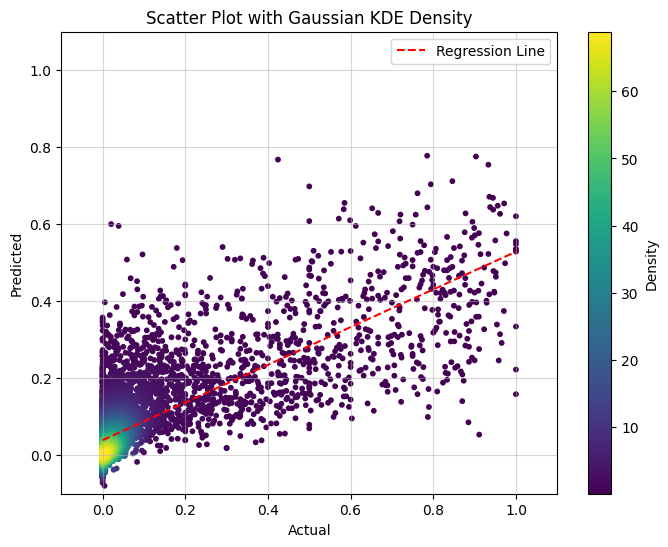

In [30]:
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
import io
import contextlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr

# Load dataset
data = pd.read_csv(save_path)
predicted = data['Predicted'].values
actual = data['Actual']
pearson_r = pearsonr(actual, predicted)[0]
print(f"Pearson correlation: {pearson_r:.4f}")

# Calculate density using Gaussian KDE
xy = np.vstack([actual, predicted])
density = gaussian_kde(xy)(xy)

# Sort points by density for better visualization
sorted_indices = density.argsort()
actual_sorted = actual[sorted_indices]
predicted_sorted = predicted[sorted_indices]
density_sorted = density[sorted_indices]

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    actual_sorted,
    predicted_sorted,
    c=density_sorted,
    cmap='viridis',
    s=10
)
plt.colorbar(scatter, label='Density')
plt.plot(
    np.unique(actual),
    np.poly1d(np.polyfit(actual, predicted, 1))(np.unique(actual)),
    color='red',
    linestyle='--',
    label='Regression Line'
)
plt.title('Scatter Plot with Gaussian KDE Density')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid(alpha=0.5)
plt.show()
